In [ ]:
pip install sklearn-quantile

In [1]:
import pandas as pd
import os
from datetime import datetime
from datetime import datetime, timedelta
import time as time_lib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.stats import gaussian_kde
import matplotlib.dates as mdates
from scipy.optimize import linprog
import matplotlib.gridspec as gridspec
from Formulation.P1formulation import P1formulation
from Formulation.P3formulation import P3formulation
import pickle
from sklearn.linear_model import QuantileRegressor
from sklearn.metrics import mean_pinball_loss

from sklearn_quantile import (
    RandomForestQuantileRegressor,
    SampleRandomForestQuantileRegressor,
)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from pprint import pprint
import statsmodels.api as sm

In [2]:
def report_savefig(plotname):
    fig_folder_path = "/Users/worachitjdai/Thesis/conference_code/figures/"
    fig.savefig(fig_folder_path+plotname+".pdf",format='pdf',bbox_inches='tight',pad_inches=0,transparent=True)

In [3]:
# ax --> figure
# x,y,z ---> lists of x and y (points), z is annotate list
# num_show ---> annotate for index that mod with num_show = 0
def annotate_fig(ax,x,y,z,num_show,color=None, xytext_default=(-5, 5),fontsize=None):
    for i, (X, Y, Z) in enumerate(zip(x, y, z)):
        if i%num_show ==0:
            ax.annotate('{}'.format(round(Z,2)), xy=(X,Y), xytext=xytext_default, ha='right',
                        textcoords='offset points',color=color,fontsize = fontsize)

In [4]:
def PICP(y,upper,lower):
    PICP = sum((y > lower) & (y < upper))/y.shape[0]
    return PICP
def widthavgcal(upper,lower):
    widthavg = (upper-lower).mean()
    return widthavg
def widthmaxcal(upper,lower):
    widthmax = (upper-lower).max()
    return widthmax
def widthonenormcal(upper, lower):
    widthonenorm = np.linalg.norm(upper-lower,1)/upper.shape[0]
    return widthonenorm

In [5]:
resultfolderpath = "/Users/worachitjdai/Thesis/conference_code/results"
datasimfolderpath = "/Users/worachitjdai/Thesis/conference_code/data/simulated_data"
datasolarfolderpath = "/Users/worachitjdai/Thesis/conference_code/data/solar_experiment"

# Preprocessing Data

In [6]:
filename = 'site001_dataprepare_forecast.csv'
df = pd.read_csv(os.path.join(datasolarfolderpath,filename), index_col='Datetime', parse_dates=['Datetime'])
df.head()

,Temperature,Relative_Humidity,Pressure,Wind_speed,Wind_direction,Rainfall,Short_wave_irradiation,I,Iclr,hour_index,I_lag30,I_lag45,CI_lag30,R_lag30
Datetime,,,,,,,,,,,,,,
2022-04-01 08:45:00,308.13,38.32,1006.13,5.71,28.78,0.0,278.2168,536.3066,594.551229,-3.5,413.5059,357.6841,0.054902,0.305882
2022-04-01 09:00:00,308.06,38.34,1005.97,5.80,28.60,0.0,239.3480,604.1268,653.535674,-2.5,471.1933,413.5059,0.050980,0.290196
2022-04-01 09:15:00,307.70,39.64,1006.15,5.90,30.95,0.0,202.4816,661.4119,709.505601,-2.5,536.3066,471.1933,0.050980,0.290196
2022-04-01 09:30:00,307.33,40.95,1006.33,6.02,33.21,0.0,167.9160,723.4158,762.194726,-2.5,604.1268,536.3066,0.050980,0.290196
2022-04-01 09:45:00,306.97,42.25,1006.51,6.14,35.38,0.0,135.9256,773.8237,811.358317,-2.5,661.4119,604.1268,0.050980,0.290196


## Features preparation

In [7]:
# Morning features
df['Temperature:Relative_Humidity'] = df['Temperature']*df['Relative_Humidity']
df['Temperature:Wind_speed'] = df['Temperature']*df['Wind_speed']
df['Temperature:Wind_direction'] = df['Temperature']*df['Wind_direction']
df['Temperature:Iclr'] = df['Temperature']*df['Iclr']
df['Temperature:I_lag30'] = df['Temperature']*df['I_lag30']
df['Relative_Humidity:Rainfall'] = df['Relative_Humidity']*df['Rainfall']
df['Relative_Humidity:Short_wave_irradiation'] = df['Relative_Humidity']*df['Short_wave_irradiation']
df['Relative_Humidity:I_lag30'] = df['Relative_Humidity']*df['I_lag30']
df['Pressure:Wind_speed'] = df['Pressure']*df['Wind_speed']
df['Wind_speed:Iclr'] = df['Wind_speed']*df['Iclr']
df['Wind_direction:Rainfall'] = df['Wind_direction']*df['Rainfall']
df['Short_wave_irradiation:Iclr'] = df['Short_wave_irradiation']*df['Iclr']
df['Iclr:I_lag30'] = df['Iclr']*df['I_lag30']
df['Iclr:CI_lag30'] = df['Iclr']*df['CI_lag30']
df['I_lag30:CI_lag30'] = df['I_lag30']*df['CI_lag30']
df['CI_lag30:R_lag30'] = df['CI_lag30']*df['R_lag30']
df['I_lag30^2'] = df['I_lag30']**2
# Noon features
df['Relative_Humidity:Wind_speed'] = df['Relative_Humidity']*df['Wind_speed']
df['Wind_speed:Rainfall'] = df['Wind_speed']*df['Rainfall']
df['Wind_direction:hour_index'] = df['Wind_direction']*df['hour_index']
df['Rainfall:Iclr'] = df['Rainfall']*df['Iclr']
df['I_lag30:I_lag45'] = df['I_lag30']*df['I_lag45']
df['I_lag30:R_lag30'] = df['I_lag30']*df['R_lag30']
df['Wind_direction^2'] = df['Wind_direction']**2
# Evening features
df['Pressure:R_lag30'] = df['Pressure']*df['R_lag30']
df['I_lag45:CI_lag30'] = df['I_lag45']*df['CI_lag30']
df['Relative_Humidity^2'] = df['Relative_Humidity']**2
df['I_lag45^2'] = df['I_lag45']**2

In [8]:
morning_features = ['Temperature', 'Relative_Humidity', 'Pressure', 'Wind_speed', 'Wind_direction', 'Rainfall', 
                    'Short_wave_irradiation', 'Iclr', 'I_lag30', 'CI_lag30', 'R_lag30', 'Temperature:Relative_Humidity', 
                    'Temperature:Wind_speed', 'Temperature:Wind_direction', 'Temperature:Iclr', 'Temperature:I_lag30', 
                    'Relative_Humidity:Rainfall', 'Relative_Humidity:Short_wave_irradiation', 'Relative_Humidity:I_lag30', 
                    'Pressure:Wind_speed', 'Wind_speed:Iclr', 'Wind_direction:Rainfall', 'Short_wave_irradiation:Iclr', 
                    'Iclr:I_lag30', 'Iclr:CI_lag30', 'I_lag30:CI_lag30', 'CI_lag30:R_lag30', 'I_lag30^2']

noon_features = ['Temperature', 'Relative_Humidity', 'Wind_speed', 'Wind_direction', 'Rainfall', 'Iclr', 'hour_index',
                 'I_lag30', 'I_lag45', 'CI_lag30', 'R_lag30', 'Temperature:Wind_direction', 'Temperature:I_lag30', 
                 'Relative_Humidity:Wind_speed', 'Relative_Humidity:I_lag30', 'Wind_speed:Rainfall', 'Wind_direction:hour_index',
                 'Rainfall:Iclr', 'Iclr:I_lag30', 'Iclr:CI_lag30', 'I_lag30:I_lag45', 'I_lag30:CI_lag30', 'I_lag30:R_lag30',
                 'CI_lag30:R_lag30', 'Wind_direction^2', 'I_lag30^2']

evening_features = ['Relative_Humidity', 'Pressure', 'Rainfall', 'Iclr', 'I_lag30', 'I_lag45', 
                    'CI_lag30', 'R_lag30', 'Pressure:R_lag30', 'Rainfall:Iclr', 'Iclr:I_lag30', 
                    'I_lag30:CI_lag30', 'I_lag30:R_lag30', 'I_lag45:CI_lag30', 'Relative_Humidity^2', 
                    'I_lag30^2', 'I_lag45^2']

In [9]:
df.head()

,Temperature,Relative_Humidity,Pressure,Wind_speed,Wind_direction,Rainfall,Short_wave_irradiation,I,Iclr,hour_index,...,Wind_speed:Rainfall,Wind_direction:hour_index,Rainfall:Iclr,I_lag30:I_lag45,I_lag30:R_lag30,Wind_direction^2,Pressure:R_lag30,I_lag45:CI_lag30,Relative_Humidity^2,I_lag45^2
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-04-01 08:45:00,308.13,38.32,1006.13,5.71,28.78,0.0,278.2168,536.3066,594.551229,-3.5,...,0.0,-100.730,0.0,147904.485686,126.484158,828.2884,307.757412,19.637558,1468.4224,127937.915393
2022-04-01 09:00:00,308.06,38.34,1005.97,5.80,28.60,0.0,239.3480,604.1268,653.535674,-2.5,...,0.0,-71.500,0.0,194841.209590,136.738448,817.9600,291.928549,21.080693,1469.9556,170987.129335
2022-04-01 09:15:00,307.70,39.64,1006.15,5.90,30.95,0.0,202.4816,661.4119,709.505601,-2.5,...,0.0,-77.375,0.0,252704.076666,155.634072,957.9025,291.980784,24.021619,1571.3296,222023.125965
2022-04-01 09:30:00,307.33,40.95,1006.33,6.02,33.21,0.0,167.9160,723.4158,762.194726,-2.5,...,0.0,-83.025,0.0,323997.190077,175.315228,1102.9041,292.033020,27.341121,1676.9025,287624.769204
2022-04-01 09:45:00,306.97,42.25,1006.51,6.14,35.38,0.0,135.9256,773.8237,811.358317,-2.5,...,0.0,-88.450,0.0,399576.654629,191.939140,1251.7444,292.085255,30.798621,1785.0625,364969.190478


## Split data into morning, noon, and evening

In [10]:
#Use 2023-01-01 : 2023-06-30 in testset
test_start = "2023-01-01"
test_end = "2023-06-30"
test = df.loc[test_start:test_end]
train = df.drop(test.index)

train_morning = train.between_time('7:00','9:45')
train_noon = train.between_time('10:00','15:00')
train_evening = train.between_time('15:15','17:00')

## Prepare features in each period

In [11]:
X_train_morning = train_morning[morning_features]
X_train_noon = train_noon[noon_features]
X_train_evening = train_evening[evening_features]
All_X_train = [X_train_morning,X_train_noon,X_train_evening]

y_train_morning = train_morning[['I']]
y_train_noon = train_noon[['I']]
y_train_evening = train_evening[['I']]

All_y_train_P1 = [y_train_morning.copy(deep=True),y_train_noon.copy(deep=True),y_train_evening.copy(deep=True)]
All_y_train_P3 = [y_train_morning.copy(deep=True),y_train_noon.copy(deep=True),y_train_evening.copy(deep=True)]
All_y_train_QR = [y_train_morning.copy(deep=True),y_train_noon.copy(deep=True),y_train_evening.copy(deep=True)]
All_y_train_QRF = [y_train_morning.copy(deep=True),y_train_noon.copy(deep=True),y_train_evening.copy(deep=True)]
All_y_train_P3_05 = [y_train_morning.copy(deep=True),y_train_noon.copy(deep=True),y_train_evening.copy(deep=True)]

## Test dataset

In [12]:
test_morning = test.between_time('7:00','09:45')
test_noon = test.between_time('10:00','15:00')
test_evening = test.between_time('15:15','17:00')

X_test_morning = test_morning[morning_features]
X_test_noon = test_noon[noon_features]
X_test_evening = test_evening[evening_features]
All_X_test = [X_test_morning,X_test_noon,X_test_evening] #For QR and QRF

y_test_morning = test_morning[['I']]
y_test_noon = test_noon[['I']]
y_test_evening = test_evening[['I']]

X_test_morning_augment_one = np.block([np.ones((X_test_morning.shape[0],1)),X_test_morning])
X_test_noon_augment_one = np.block([np.ones((X_test_noon.shape[0],1)),X_test_noon])
X_test_evening_augment_one = np.block([np.ones((X_test_evening.shape[0],1)),X_test_evening])
All_X_test_augment_one = [X_test_morning_augment_one,X_test_noon_augment_one,X_test_evening_augment_one] #For P1, P3

All_y_test_P1 = [y_test_morning.copy(deep=True),y_test_noon.copy(deep=True),y_test_evening.copy(deep=True)] #P1
All_y_test_P3 = [y_test_morning.copy(deep=True),y_test_noon.copy(deep=True),y_test_evening.copy(deep=True)]
All_y_test_QR = [y_test_morning.copy(deep=True),y_test_noon.copy(deep=True),y_test_evening.copy(deep=True)]
All_y_test_QRF = [y_test_morning.copy(deep=True),y_test_noon.copy(deep=True),y_test_evening.copy(deep=True)]
All_y_test_P3_05 = [y_test_morning.copy(deep=True),y_test_noon.copy(deep=True),y_test_evening.copy(deep=True)]

## Calculating coefficient that $\hat{P} = \hat{a}\hat{I}$

In [13]:
filename = 'ISL_data_20220101_20230630.csv'
site = 'ISL001'

df_measure = pd.read_csv(os.path.join(datasolarfolderpath,filename),index_col='Datetime',parse_dates=['Datetime'])
df_measure = df_measure[df_measure['site_name']==site]
df_measure = df_measure.dropna()
df_measure = df_measure.between_time('07:00','17:00')
df_measure = df_measure[(df_measure != 0).all(axis=1)]
N = 1000 #Number of samples
df_measure = df_measure.sample(n=N)

In [14]:
ac_capacity = 875
x = np.array(df_measure['measure_ghi'])/1000 #convert unit to kW/sqm
y = np.array(df_measure['generated_power'])/ac_capacity #convert unit to per unit power

In [15]:
model = sm.OLS(y, x).fit()
model.save(os.path.join(resultfolderpath, 'converting_i_p.pickle'))
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                          2.041e+05
Date:                Wed, 17 Jan 2024   Prob (F-statistic):                        0.00
Time:                        21:01:56   Log-Likelihood:                          2009.4
No. Observations:                1000   AIC:                                     -4017.
Df Residuals:                     999   BIC:                                     -4012.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

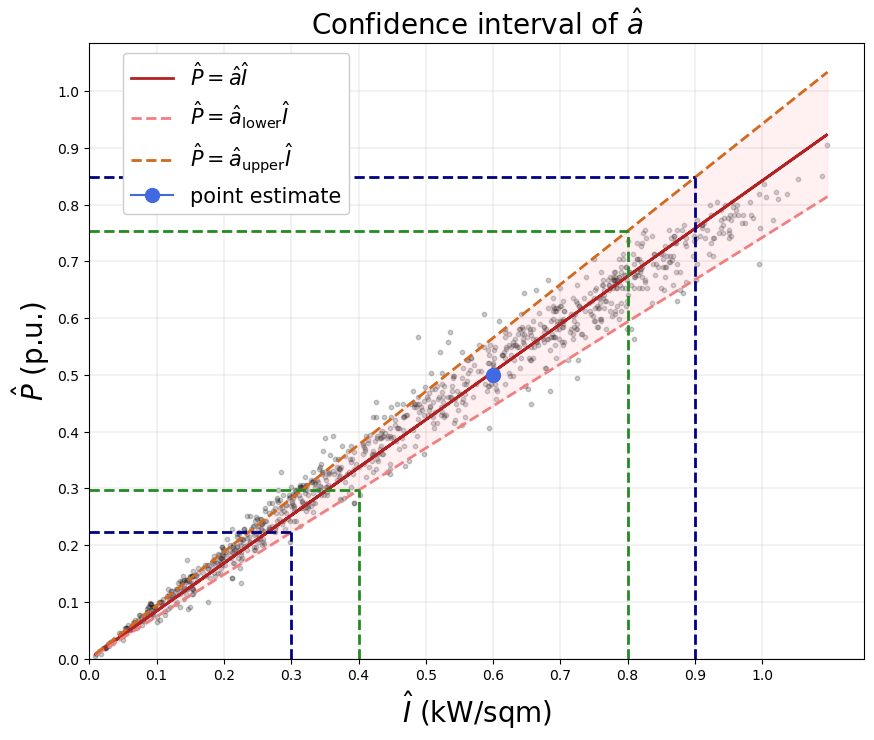

In [16]:
fig,ax = plt.subplots()
fig.set_size_inches(10, 8)
alpha = 0.05 # 95% interval
# Real confidence interval
confidence_interval = model.conf_int(alpha)
# Confidence interval for showing
std = 0.1
confidence_interval = np.array([[model.params[0]-std,model.params[0]+std]])

x_sort = np.sort(x)
y_pred_stat = model.predict(x)
l = confidence_interval[0,0]*x_sort
u = confidence_interval[0,1]*x_sort

color_list = ['indianred']
ax.scatter(x,y,s=10,color='k',alpha=0.2)
ax.plot(x,y_pred_stat,color = 'firebrick', linewidth=2, label = r'$\hat{P} = \hat{a} \hat{I}$')
ax.plot(x_sort,l, color = 'lightcoral',linestyle = 'dashed', linewidth=2, label = r'$\hat{P} = \hat{a}_{\text{lower}} \hat{I}$')
ax.plot(x_sort,u, color = 'chocolate',linestyle = 'dashed', linewidth=2, label = r'$\hat{P} = \hat{a}_{\text{upper}} \hat{I}$')

#Deterministic plot
ax.plot(0.6, 0.5, color = 'royalblue',marker = 'o', markersize = 10, label = 'point estimate')
ax.fill_between(x_sort, l, u, color = 'lightpink', alpha = 0.2)

piwidth = [0.4,0.6]
low = 0.4
high = 0.3
low_pi = [low,low + piwidth[0]]
high_pi = [high, high + piwidth[1]]
color_list = ['forestgreen', 'navy']

for i in range(len(low_pi)):
    ax.plot([low_pi[i], low_pi[i]], [0, low_pi[i]*confidence_interval[0,i]], linestyle='--', color=color_list[0], linewidth=2)
    ax.plot([0, low_pi[i]], [low_pi[i]*confidence_interval[0,i], low_pi[i]*confidence_interval[0,i]], linestyle='--', color=color_list[0], linewidth=2)
    ax.plot([high_pi[i], high_pi[i]], [0, high_pi[i]*confidence_interval[0,i]], linestyle='--', color=color_list[1], linewidth=2)
    ax.plot([0, high_pi[i]], [high_pi[i]*confidence_interval[0,i], high_pi[i]*confidence_interval[0,i]], linestyle='--', color=color_list[1], linewidth=2)

ax.set_xlabel('$\hat{I}$ (kW/sqm)',fontsize = 20)
ax.set_ylabel('$\hat{P}$ (p.u.)', fontsize = 20)
ax.set_title(r'Confidence interval of $\hat{a}$',fontsize = 20)
ax.set_xlim(0)
ax.set_ylim(0)

ax.xaxis.set_ticks(np.arange(0, np.max(x), 0.1))
ax.yaxis.set_ticks(np.arange(0, np.max(u), 0.1))


ax.grid(color='k', linestyle='dashed', linewidth=0.1)
ax.legend(fontsize = 15, framealpha = 1, loc = 'upper left', bbox_to_anchor=(0.03, 1))


# Quantile Regression

In [ ]:
quantiles = [0.05,0.95]
beta_qr = {}
pinball_loss_QR = {}
conf_interval_list = list(np.round(np.arange(0.1, 0.91, 0.05),2))
for i in range(len(All_X_train)):
    if i == 0:
        period = "morning"
    elif i == 1:
        period = "noon"
    else:
        period = "evening"
    X_train = All_X_train[i]
    y_train_qr = All_y_train_QR[i]
    n_samples = X_train.shape[0]
    print(str(period))
    for conf_int in conf_interval_list:
        print('-----For nominal confidence level : '+str(conf_int)+'-----')
        quantiles_vary = [round((1-conf_int)/2,4),round((1+conf_int)/2,4)]
        for quantile in quantiles_vary:
            qr = QuantileRegressor(quantile=quantile,alpha = 0, fit_intercept=True,solver='highs')
            model = qr.fit(X_train, y_train_qr['I'])
            All_y_train_QR[i].loc[:,"Quantile: "+str(quantile)] = model.predict(X_train)
            beta_qr[(period,quantile)]= [model.intercept_,model.coef_[0:X_train.shape[1]]]
            pinball_loss_QR[(period,quantile)] = [mean_pinball_loss(All_y_train_QR[i]['I'],All_y_train_QR[i]['Quantile: '+str(quantile)],alpha = quantile)]    
            # For test data
            All_y_test_QR[i].loc[:,"Quantile: "+str(quantile)] = model.predict(All_X_test[i])
# Save train result
All_y_train_QR[0].to_csv(os.path.join(resultfolderpath,'qr_morning.csv'))
All_y_train_QR[1].to_csv(os.path.join(resultfolderpath,'qr_noon.csv'))
All_y_train_QR[2].to_csv(os.path.join(resultfolderpath,'qr_evening.csv'))
# Save test result
All_y_test_QR[0].to_csv(os.path.join(resultfolderpath,'qr_morning_test.csv'))
All_y_test_QR[1].to_csv(os.path.join(resultfolderpath,'qr_noon_test.csv'))
All_y_test_QR[2].to_csv(os.path.join(resultfolderpath,'qr_evening_test.csv'))

# Save QR parameter (beta)
dict_path = os.path.join(resultfolderpath, 'beta_qr.pkl')
with open(dict_path,'wb') as pickle_file:
    pickle.dump(beta_qr,pickle_file)
    
dict_path = os.path.join(resultfolderpath, 'pinball_qr.pkl')
with open(dict_path,'wb') as pickle_file:
    pickle.dump(pinball_loss_QR,pickle_file)


## Import the result

In [17]:
# Load QR result
quantiles = [0.05,0.95]
conf_interval_list = list(np.round(np.arange(0.1, 0.91, 0.05),2))
qr_morning = pd.read_csv(os.path.join(resultfolderpath,'qr_morning.csv'), index_col='Datetime', parse_dates=['Datetime'])
qr_noon = pd.read_csv(os.path.join(resultfolderpath,'qr_noon.csv'), index_col='Datetime', parse_dates=['Datetime'])
qr_evening = pd.read_csv(os.path.join(resultfolderpath,'qr_evening.csv'), index_col='Datetime', parse_dates=['Datetime'])
All_y_train_QR = [qr_morning,qr_noon,qr_evening]

# Load the dictionary from the Pickle file
dict_path = os.path.join(resultfolderpath, 'beta_qr.pkl')
with open(dict_path, 'rb') as pickle_file:
    beta_qr = pickle.load(pickle_file)
dict_path = os.path.join(resultfolderpath, 'pinball_qr.pkl')
with open(dict_path, 'rb') as pickle_file:
    pinball_loss_QR = pickle.load(pickle_file)

In [18]:
All_y_train_QR[0].head()

,I,Quantile: 0.45,Quantile: 0.55,Quantile: 0.425,Quantile: 0.575,Quantile: 0.4,Quantile: 0.6,Quantile: 0.375,Quantile: 0.625,Quantile: 0.35,...,Quantile: 0.15,Quantile: 0.85,Quantile: 0.125,Quantile: 0.875,Quantile: 0.1,Quantile: 0.9,Quantile: 0.075,Quantile: 0.925,Quantile: 0.05,Quantile: 0.95
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-04-01 08:45:00,536.3066,503.494657,507.948283,500.132344,506.206576,498.224213,508.437351,498.598512,509.177303,498.649762,...,458.721327,541.568833,448.978744,541.306633,431.672025,544.087450,413.506077,550.251617,395.818209,558.022432
2022-04-01 09:00:00,604.1268,560.430884,565.929136,557.647148,562.720937,555.957563,564.915327,556.463124,565.773856,555.976298,...,506.640788,601.726008,497.819498,601.491112,478.040543,604.193885,455.518622,611.311425,439.816898,620.431285
2022-04-01 09:15:00,661.4119,618.912024,626.102569,616.728286,622.204806,615.459949,624.020314,615.578708,624.351684,614.246737,...,549.928546,661.411900,542.695458,661.411900,520.606579,663.412650,495.036444,671.406086,478.660784,682.209550
2022-04-01 09:30:00,723.4158,674.813252,683.471146,673.485699,679.142464,672.795887,680.617335,672.411402,680.248973,670.183890,...,586.823201,715.415339,581.569022,715.523311,557.827579,716.345914,530.513164,724.777921,513.015199,736.852459
2022-04-01 09:45:00,773.8237,721.551932,732.113333,721.028587,727.906483,720.863700,729.169338,719.854799,728.309762,716.542429,...,612.502783,763.650572,609.338450,764.415335,584.684296,764.752441,556.002631,773.823700,537.616124,787.820442


## PICP, width, quantile score calculation

In [19]:
#Calculate width and PICP
width_dict_QR = {("morning","avg"):[],("morning","max"):[],("morning","norm1"):[],
     ("noon","avg"):[],("noon","max"):[],("noon","norm1"):[],
     ("evening","avg"):[],("evening","max"):[],("evening","norm1"):[]}
PICP_QR = {}
QS_score_QR = {}

for i in range(len(All_X_train)):
    PICP_list = []
    QS_score_each_period = []
    if i == 0:
        period = "morning"
    elif i == 1:
        period = "noon"
    else:
        period = "evening"
    for conf_int in conf_interval_list:
        quantiles_vary = [round((1-conf_int)/2,4),round((1+conf_int)/2,4)]
        upper = All_y_train_QR[i]["Quantile: "+str(quantiles_vary[1])]
        lower = All_y_train_QR[i]["Quantile: "+str(quantiles_vary[0])]
        measure = All_y_train_QR[i]['I']
        width_dict_QR[(period,'avg')].append(widthavgcal(upper, lower))
        width_dict_QR[(period,'max')].append(widthmaxcal(upper, lower))
        width_dict_QR[(period,'norm1')].append(widthonenormcal(upper, lower))

        PICP_linprog_train_QR = PICP(measure, upper, lower)
        PICP_list.append(PICP_linprog_train_QR)
        PICP_QR[period]=PICP_list

        QS_score_each_period.append((pinball_loss_QR[period,quantiles_vary[0]][0]+pinball_loss_QR[period,quantiles_vary[1]][0])/len(quantiles_vary))
    QS_score_QR[period] = QS_score_each_period

In [ ]:
# Save
dict_save = [width_dict_QR, PICP_QR, QS_score_QR]
dict_save_name = ['width_dict_qr.pkl', 'picp_dict_qr.pkl', 'qsscore_dict_qr.pkl']
for i in range(len(dict_save)):
    with open(os.path.join(resultfolderpath, dict_save_name[i]),'wb') as pickle_file:
        pickle.dump(dict_save[i],pickle_file)

# Quantile Regression Forest

## Grid search for hyperparameters

In [ ]:
param_grid = dict(
        n_estimators=[50, 100, 150, 200, 250, 300],
        max_depth=[2, 5, 10, 15, 20, 25, 30, 40],
        min_samples_leaf=[1, 4, 8, 10, 20, 30, 40],
        min_samples_split=[2, 5, 10, 20, 30, 50],
        max_features = ["sqrt"])
quantiles = [0.05, 0.95]

for i in range(len(All_X_train)):
    if i == 0:
        period = "morning"
    elif i == 1:
        period = "noon"
    else:
        period = "evening"
    X_train = All_X_train[i]
    y_train_qrf = All_y_train_QRF[i]['I']
    n_samples = X_train.shape[0]
    
    for q in quantiles:
        neg_mean_pinball_loss_scorer = make_scorer(
            mean_pinball_loss,
            alpha=q,
            greater_is_better=False,  # maximize the negative loss
        )
        qrf = RandomForestQuantileRegressor(random_state=0, q=q)
        search_p = RandomizedSearchCV(
            qrf,
            param_grid,
            n_iter=10,  # increase this if computational budget allows
            scoring=neg_mean_pinball_loss_scorer,
            n_jobs=2,
            random_state=0,
        ).fit(X_train, y_train_qrf)
        print('-----'+str(period)+'-----')
        print('-- For '+str(q)+' --')
        pprint(search_p.best_params_)

## Performing QRF

In [ ]:
pinball_loss_QRF = {}
conf_interval_list = list(np.round(np.arange(0.1, 0.91, 0.05),2))
for i in range(len(All_X_train)):
    if i == 0:
        period = "morning"
    elif i == 1:
        period = "noon"
    else:
        period = "evening"
    X_train = All_X_train[i]
    y_train_qrf = All_y_train_QRF[i]['I']
    n_samples = X_train.shape[0]
    print(str(period))
    for conf_int in conf_interval_list:
        print('-----For nominal confidence level : '+str(conf_int)+'-----')
        quantiles_vary = [round((1-conf_int)/2,4),round((1+conf_int)/2,4)]
        for quantile in quantiles_vary:
            if i == 0: #Morning
                if quantile == quantiles_vary[0]: #For lower bound
                    common_params = dict(max_depth=10,
                                            max_features = "sqrt",
                                            min_samples_leaf=4,
                                            min_samples_split=20,
                                            n_estimators=100)
                else: #For upper bound
                    common_params = dict(max_depth=15,
                                            max_features = "sqrt",
                                            min_samples_leaf=8,
                                            min_samples_split=5,
                                            n_estimators=100)                
            elif i == 1: #Noon
                if quantile == quantiles_vary[0]: #For lower bound
                    common_params = dict(max_depth=25,
                                            max_features = "sqrt",
                                            min_samples_leaf=10,
                                            min_samples_split=10,
                                            n_estimators=200)                    
                else: #For upper bound
                    common_params = dict(max_depth=25,
                                            max_features = "sqrt",
                                            min_samples_leaf=10,
                                            min_samples_split=10,
                                            n_estimators=200)                
            else: #Evening
                if quantile == quantiles_vary[0]: #For lower bound
                    common_params = dict(max_depth=20,
                                            max_features = "sqrt",
                                            min_samples_leaf=30,
                                            min_samples_split=30,
                                            n_estimators=250)                    
                else: #For upper bound
                    common_params = dict(max_depth=25,
                                            max_features = "sqrt",
                                            min_samples_leaf=10,
                                            min_samples_split=10,
                                            n_estimators=200)                            
            qrf = RandomForestQuantileRegressor(**common_params, q=quantile)
            qrf.fit(X_train, y_train_qrf)
            All_y_train_QRF[i].loc[:,"QRF Quantile: "+str(quantile)] = qrf.predict(X_train)
            pinball_loss_QRF[(period,quantile)] = [mean_pinball_loss(All_y_train_QRF[i]['I'],All_y_train_QRF[i]['QRF Quantile: '+str(quantile)],alpha = quantile)]    
            # For test data
            All_y_test_QRF[i].loc[:,"QRF Quantile: "+str(quantile)] = qrf.predict(All_X_test[i])
# Save result
All_y_train_QRF[0].to_csv(os.path.join(resultfolderpath,'qrf_morning.csv'))
All_y_train_QRF[1].to_csv(os.path.join(resultfolderpath,'qrf_noon.csv'))
All_y_train_QRF[2].to_csv(os.path.join(resultfolderpath,'qrf_evening.csv'))
# Save result
All_y_test_QRF[0].to_csv(os.path.join(resultfolderpath,'qrf_morning_test.csv'))
All_y_test_QRF[1].to_csv(os.path.join(resultfolderpath,'qrf_noon_test.csv'))
All_y_test_QRF[2].to_csv(os.path.join(resultfolderpath,'qrf_evening_test.csv'))



## Import the result

In [20]:
# Load QRF result
quantiles = [0.05,0.95]
qrf_morning = pd.read_csv(os.path.join(resultfolderpath,'qrf_morning.csv'), index_col='Datetime', parse_dates=['Datetime'])
qrf_noon = pd.read_csv(os.path.join(resultfolderpath,'qrf_noon.csv'), index_col='Datetime', parse_dates=['Datetime'])
qrf_evening = pd.read_csv(os.path.join(resultfolderpath,'qrf_evening.csv'), index_col='Datetime', parse_dates=['Datetime'])
All_y_train_QRF = [qrf_morning,qrf_noon,qrf_evening]

qrf_morning_test = pd.read_csv(os.path.join(resultfolderpath,'qrf_morning_test.csv'), index_col='Datetime', parse_dates=['Datetime'])
qrf_noon_test = pd.read_csv(os.path.join(resultfolderpath,'qrf_noon_test.csv'), index_col='Datetime', parse_dates=['Datetime'])
qrf_evening_test = pd.read_csv(os.path.join(resultfolderpath,'qrf_evening_test.csv'), index_col='Datetime', parse_dates=['Datetime'])
All_y_test_QRF = [qrf_morning_test, qrf_noon_test, qrf_evening_test]

## PICP, width calculation

In [21]:
#Calculate width
width_dict_QRF = {("morning","avg"):[],("morning","max"):[],("morning","norm1"):[],
     ("noon","avg"):[],("noon","max"):[],("noon","norm1"):[],
     ("evening","avg"):[],("evening","max"):[],("evening","norm1"):[]}
PICP_QRF = {}

for i in range(len(All_X_train)):
    PICP_list = []
    if i == 0:
        period = "morning"
    elif i == 1:
        period = "noon"
    else:
        period = "evening"
    for conf_int in conf_interval_list:
        quantiles_vary = [round((1-conf_int)/2,4),round((1+conf_int)/2,4)]
        upper = All_y_train_QRF[i]["QRF Quantile: "+str(quantiles_vary[1])]
        lower = All_y_train_QRF[i]["QRF Quantile: "+str(quantiles_vary[0])]
        measure = All_y_train_QRF[i]['I']
        width_dict_QRF[(period,'avg')].append(widthavgcal(upper, lower))
        width_dict_QRF[(period,'max')].append(widthmaxcal(upper, lower))
        width_dict_QRF[(period,'norm1')].append(widthonenormcal(upper, lower))

        PICP_linprog_train_QRF = PICP(measure, upper, lower)
        PICP_list.append(PICP_linprog_train_QRF)
        PICP_QRF[period]=PICP_list

In [ ]:
# Save
dict_save = [width_dict_QRF, PICP_QRF]
dict_save_name = ['width_dict_qrf.pkl', 'picp_dict_qrf.pkl']
for i in range(len(dict_save)):
    with open(os.path.join(resultfolderpath, dict_save_name[i]),'wb') as pickle_file:
        pickle.dump(dict_save[i],pickle_file)

# Formulation P1 (control average width)
\begin{equation}
\begin{array}{ll}
\underset{\underline{\beta},\overline{\beta}}{ \mbox{minimize} }
		& \sum_{i \in \mathcal{I}} [ \rho_{\underline{\alpha}}(y_{i}-\hat{l}_{i}(\underline{\beta}))+\rho_{\overline{\alpha}}(y_{i}-\hat{u}_{i}(\overline{\beta})) ] \\
		\text{subject to} & 0 \leq \hat{l}_{i}(\underline{\beta}) \leq \hat{u}_{i}(\overline{\beta}), \forall i \in \mathcal{I},\\
      &  \frac{1}{N}\sum_{i \in \mathcal{I}} [ \hat{u}_{i}(\overline{\beta})-\hat{l}_{i}(\underline{\beta}) ]  \leq \gamma \cdot \text{sample width},
\end{array}
\end{equation}




In [ ]:
#Run with separated time
quantiles = [0.05,0.95]
dec_factor = list(np.round(np.arange(0.02, 1.02, 0.02),2))
beta_model_P1 = {}

for i in range(len(All_X_train)):
    if i == 0:
        period = "morning"
    elif i == 1:
        period = "noon"
    else:
        period = "evening"
    print("---------"+period+"---------")
    X_train = All_X_train[i]
    n_samples = X_train.shape[0]
    # Add constant term
    X_train_augment_one = np.block([np.ones((n_samples,1)),X_train])
    y_train = All_y_train_P1[i]["I"]
    p = X_train_augment_one.shape[1]

    for dec in dec_factor:
        p1 = P1formulation(nonnegative = True)
        model = p1.fit(X_train_augment_one, y_train, quantiles, dec)
        beta_model_P1[(dec,period,quantiles[0])] = model.lowercoef
        beta_model_P1[(dec,period,quantiles[1])] = model.uppercoef
        lower_pred, upper_pred = model.predict(X_train_augment_one)
        All_y_train_P1[i].loc[:,"Quantile: "+str(quantiles[0])+"Penalty: "+str(dec)] = lower_pred
        All_y_train_P1[i].loc[:,"Quantile: "+str(quantiles[1])+"Penalty: "+str(dec)] = upper_pred

# Save result
All_y_train_P1[0].to_csv(os.path.join(resultfolderpath,'p1_morning.csv'))
All_y_train_P1[1].to_csv(os.path.join(resultfolderpath,'p1_noon.csv'))
All_y_train_P1[2].to_csv(os.path.join(resultfolderpath,'p1_evening.csv'))
# Save P1 parameter (beta)
dict_path = os.path.join(resultfolderpath, 'beta_p1.pkl')
with open(dict_path,'wb') as pickle_file:
    pickle.dump(beta_model_P1,pickle_file)

## Import the result

In [ ]:
# Load P1 result
quantiles = [0.05,0.95]
dec_factor = list(np.round(np.arange(0.02, 1.02, 0.02),2))
p1_morning = pd.read_csv(os.path.join(resultfolderpath,'p1_morning.csv'), index_col='Datetime', parse_dates=['Datetime'])
p1_noon = pd.read_csv(os.path.join(resultfolderpath,'p1_noon.csv'), index_col='Datetime', parse_dates=['Datetime'])
p1_evening = pd.read_csv(os.path.join(resultfolderpath,'p1_evening.csv'), index_col='Datetime', parse_dates=['Datetime'])
All_y_train_P1 = [p1_morning,p1_noon,p1_evening]

# Load the dictionary from the Pickle file
dict_path = os.path.join(resultfolderpath, 'beta_p1.pkl')
with open(dict_path, 'rb') as pickle_file:
    beta_model_P1 = pickle.load(pickle_file)

## PICP, width, quantile score calculation

In [ ]:
#Calculate width
width_dict_P1 = {("morning","avg"):[],("morning","max"):[],("morning","norm1"):[],
     ("noon","avg"):[],("noon","max"):[],("noon","norm1"):[],
     ("evening","avg"):[],("evening","max"):[],("evening","norm1"):[]}
PICP_P1 = {}
pinball_loss_P1 = {}
QS_score_P1 = {}

for i in range(len(All_X_train)):
    PICP_list = []
    pinball_list_P1_q0 = []
    pinball_list_P1_q1 = []
    if i == 0:
        period = "morning"
    elif i == 1:
        period = "noon"
    else:
        period = "evening"
    for penalty in dec_factor:
        upper = All_y_train_P1[i]["Quantile: "+str(quantiles[1])+"Penalty: "+str(penalty)]
        lower = All_y_train_P1[i]["Quantile: "+str(quantiles[0])+"Penalty: "+str(penalty)]
        measure = All_y_train_P1[i]['I']
        
        width_dict_P1[(period,'avg')].append(widthavgcal(upper, lower))
        width_dict_P1[(period,'max')].append(widthmaxcal(upper, lower))
        width_dict_P1[(period,'norm1')].append(widthonenormcal(upper, lower))
        
        pinball_q0 = mean_pinball_loss(measure,lower,alpha = quantiles[0])
        pinball_q1 = mean_pinball_loss(measure,upper,alpha = quantiles[1])
        pinball_list_P1_q0.append(pinball_q0)
        pinball_list_P1_q1.append(pinball_q1)

        PICP_linprog_train_P1 = PICP(measure, upper, lower)
        PICP_list.append(PICP_linprog_train_P1)

    PICP_P1[period]=PICP_list
    pinball_loss_P1[(period,quantiles[0])] = pinball_list_P1_q0
    pinball_loss_P1[(period,quantiles[1])] = pinball_list_P1_q1
    QS_score_P1_list = list(np.add(pinball_loss_P1[period,quantiles[0]],pinball_loss_P1[period,quantiles[1]])/len(quantiles))
    QS_score_P1[period] = QS_score_P1_list

In [ ]:
# Save
dict_save = [width_dict_P1, PICP_P1, QS_score_P1]
dict_save_name = ['width_dict_p1.pkl', 'picp_dict_p1.pkl', 'qsscore_dict_p1.pkl']
for i in range(len(dict_save)):
    with open(os.path.join(resultfolderpath, dict_save_name[i]),'wb') as pickle_file:
        pickle.dump(dict_save[i],pickle_file)

# Formulation P2 (control large widths)
\begin{equation}
\begin{array}{ll}
\underset{\underline{\beta},\overline{\beta}}{ \mbox{minimize} }
		& \sum_{i \in \mathcal{I}} [ \rho_{\underline{\alpha}}(y_{i}-\hat{l}_{i}(\underline{\beta}))+\rho_{\overline{\alpha}}(y_{i}-\hat{u}_{i}(\overline{\beta})) ] \\
		\text{subject to} & 0 \leq \hat{l}_{i}(\underline{\beta}) \leq \hat{u}_{i}(\overline{\beta}), \forall i \in \mathcal{I},\\
      & \frac{1}{K}\sum_{i=1}^K w_{[i]}  \leq \gamma \cdot \text{sample width},
\end{array}
\end{equation}

# Formulation P3 (control maximum width)
\begin{equation}
\begin{array}{ll}
\underset{\underline{\beta},\overline{\beta}}{ \mbox{minimize} }
		& \sum_{i \in \mathcal{I}} [ \rho_{\underline{\alpha}}(y_{i}-\hat{l}_{i}(\underline{\beta}))+\rho_{\overline{\alpha}}(y_{i}-\hat{u}_{i}(\overline{\beta})) ] \\
		\text{subject to} & 0 \leq \hat{l}_{i}(\underline{\beta}) \leq \hat{u}_{i}(\overline{\beta}), \forall i \in \mathcal{I},\\
      &  \underset{i \in \mathcal{I} }{ \max } [ \hat{u}_{i}(\overline{\beta})-\hat{l}_{i}(\underline{\beta}) ] \leq \gamma \cdot \text{sample width},
\end{array}
\end{equation}


In [ ]:
# Run with time seperated
quantiles = [0.05,0.95]
dec_factor = list(np.round(np.arange(0.02, 1.02, 0.02),2))
beta_model_P3 = {}

for i in range(len(All_X_train)):
    if i == 0:
        period = "morning"
    elif i == 1:
        period = "noon"
    else:
        period = "evening"
    print("---------"+period+"---------")
    X_train = All_X_train[i]
    n_samples = X_train.shape[0]
    # Add constant term
    X_train_augment_one = np.block([np.ones((n_samples,1)),X_train])
    y_train = All_y_train_P3[i]["I"]
    p = X_train_augment_one.shape[1]
  
    for dec in dec_factor:
        p3 = P3formulation(nonnegative = True)
        model = p3.fit(X_train_augment_one, y_train, quantiles, dec)
        beta_model_P3[(dec,period,quantiles[0])] = model.lowercoef
        beta_model_P3[(dec,period,quantiles[1])] = model.uppercoef
        lower_pred, upper_pred = model.predict(X_train_augment_one)
        All_y_train_P3[i]["Quantile: "+str(quantiles[0])+"decrease factor: "+str(dec)] = lower_pred
        All_y_train_P3[i]["Quantile: "+str(quantiles[1])+"decrease factor: "+str(dec)] = upper_pred

# Save result
All_y_train_P3[0].to_csv(os.path.join(resultfolderpath,'p3_morning.csv'))
All_y_train_P3[1].to_csv(os.path.join(resultfolderpath,'p3_noon.csv'))
All_y_train_P3[2].to_csv(os.path.join(resultfolderpath,'p3_evening.csv'))
# Save P1 parameter (beta)
dict_path = os.path.join(resultfolderpath, 'beta_p3.pkl')
with open(dict_path,'wb') as pickle_file:
    pickle.dump(beta_model_P3,pickle_file)

## Import the result

In [ ]:
# Load P3 result
dec_factor = list(np.round(np.arange(0.02, 1.02, 0.02),2))
p3_morning = pd.read_csv(os.path.join(resultfolderpath,'p3_morning.csv'), index_col='Datetime', parse_dates=['Datetime'])
p3_noon = pd.read_csv(os.path.join(resultfolderpath,'p3_noon.csv'), index_col='Datetime', parse_dates=['Datetime'])
p3_evening = pd.read_csv(os.path.join(resultfolderpath,'p3_evening.csv'), index_col='Datetime', parse_dates=['Datetime'])
All_y_train_P3 = [p3_morning,p3_noon,p3_evening]

# Load the dictionary from the Pickle file
dict_path = os.path.join(resultfolderpath, 'beta_p3.pkl')
with open(dict_path, 'rb') as pickle_file:
    beta_model_P3 = pickle.load(pickle_file)

### PICP, width, quantile score calculation

In [ ]:
#Calculate width
width_dict_P3 = {("morning","avg"):[],("morning","max"):[],("morning","norm1"):[],
     ("noon","avg"):[],("noon","max"):[],("noon","norm1"):[],
     ("evening","avg"):[],("evening","max"):[],("evening","norm1"):[]}
PICP_P3 = {}
pinball_loss_P3 = {}
QS_score_P3 = {}

for i in range(len(All_X_train)):
    PICP_list = []
    pinball_list_P3_q0 = []
    pinball_list_P3_q1 = []
    if i == 0:
        period = "morning"
    elif i == 1:
        period = "noon"
    else:
        period = "evening"
    for dec in dec_factor:
        upper = All_y_train_P3[i]["Quantile: "+str(quantiles[1])+"decrease factor: "+str(dec)]
        lower = All_y_train_P3[i]["Quantile: "+str(quantiles[0])+"decrease factor: "+str(dec)]
        measure = All_y_train_P3[i]['I']
        
        width_dict_P3[(period,'avg')].append(widthavgcal(upper, lower))
        width_dict_P3[(period,'max')].append(widthmaxcal(upper, lower))
        width_dict_P3[(period,'norm1')].append(widthonenormcal(upper, lower))
        
        pinball_q0 = mean_pinball_loss(measure,lower,alpha = quantiles[0])
        pinball_q1 = mean_pinball_loss(measure,upper,alpha = quantiles[1])
        pinball_list_P3_q0.append(pinball_q0)
        pinball_list_P3_q1.append(pinball_q1)

        PICP_linprog_train_P3 = PICP(measure, upper, lower)
        PICP_list.append(PICP_linprog_train_P3)

    PICP_P3[period]=PICP_list
    pinball_loss_P3[(period,quantiles[0])] = pinball_list_P3_q0
    pinball_loss_P3[(period,quantiles[1])] = pinball_list_P3_q1
    QS_score_P3_list = list(np.add(pinball_loss_P3[period,quantiles[0]],pinball_loss_P3[period,quantiles[1]])/len(quantiles))
    QS_score_P3[period] = QS_score_P3_list

In [ ]:
# Save
dict_save = [width_dict_P3, PICP_P3, QS_score_P3]
dict_save_name = ['width_dict_p3.pkl', 'picp_dict_p3.pkl', 'qsscore_dict_p3.pkl']
for i in range(len(dict_save)):
    with open(os.path.join(resultfolderpath, dict_save_name[i]),'wb') as pickle_file:
        pickle.dump(dict_save[i],pickle_file)

## Import the result varying nominal confidence levels at $\gamma = 0.5$

In [ ]:
# Load P3 result
dec_factor = list(np.round(np.arange(0.02, 1.02, 0.02),2))
p3_morning_05 = pd.read_csv(os.path.join(resultfolderpath,'p3_05_morning.csv'), index_col='Datetime', parse_dates=['Datetime'])
p3_noon_05 = pd.read_csv(os.path.join(resultfolderpath,'p3_05_noon.csv'), index_col='Datetime', parse_dates=['Datetime'])
p3_evening_05 = pd.read_csv(os.path.join(resultfolderpath,'p3_05_evening.csv'), index_col='Datetime', parse_dates=['Datetime'])
All_y_train_P3_05 = [p3_morning_05,p3_noon_05,p3_evening_05]

# Load the dictionary from the Pickle file
dict_path = os.path.join(resultfolderpath, 'beta_p3_05.pkl')
with open(dict_path, 'rb') as pickle_file:
    beta_model_P3_05 = pickle.load(pickle_file)

### PICP calculation for $\gamma = 0.5$

In [ ]:
#Calculate PICP
PICP_P3_05 = {}
dec = 0.5
for i in range(len(All_X_train)):
    PICP_list = []
    if i == 0:
        period = "morning"
    elif i == 1:
        period = "noon"
    else:
        period = "evening"
    for conf_int in conf_interval_list:
        quantiles_vary = [round((1-conf_int)/2,4),round((1+conf_int)/2,4)]
        upper = All_y_train_P3_05[i]["Quantile: "+str(quantiles_vary[1])+"decrease factor: "+str(dec)]
        lower = All_y_train_P3_05[i]["Quantile: "+str(quantiles_vary[0])+"decrease factor: "+str(dec)]
        measure = All_y_train_P3_05[i]['I']
        
        PICP_linprog_train_P3 = PICP(measure, upper, lower)
        PICP_list.append(PICP_linprog_train_P3)
    PICP_P3_05[period]=PICP_list

In [ ]:
# Save
dict_save = [PICP_P3_05]
dict_save_name = ['picp_dict_p3_05.pkl']
for i in range(len(dict_save)):
    with open(os.path.join(resultfolderpath, dict_save_name[i]),'wb') as pickle_file:
        pickle.dump(dict_save[i],pickle_file)

# Compare the results of QR, P1, P3

## PICP and PI widths

In [ ]:
## PICP and width tradeoff
nrows = 2
ncols = 3
fig,ax = plt.subplots(nrows=nrows,ncols=ncols)
fig.set_size_inches(15, 12)
color_list = ['indianred','lightblue','forestgreen']
widthtypelist = {'norm1':'Average','max':'Max'}

for i in range(len(All_X_train)):
    if i == 0:
        period = "morning"
        qrf_end = -3
    elif i == 1:
        period = "noon"
        qrf_end = -3
    else:
        period = "evening"
        qrf_end = -2

    j  = 0
    for widthtype in widthtypelist:
        ax[j,i].plot(PICP_QR[period],width_dict_QR[period,widthtype],c=color_list[0],marker="o",label=widthtypelist[widthtype]+' width (QR)')
        annotate_fig(ax[j,i],PICP_QR[period],width_dict_QR[period,widthtype],conf_interval_list,2,xytext_default=(-5,5),color=color_list[0])
        
        ax[j,i].plot(PICP_QRF[period][0:qrf_end],width_dict_QRF[period,widthtype][0:qrf_end],c=color_list[1],marker="s",label=widthtypelist[widthtype]+' width (QRF)')    
        annotate_fig(ax[j,i],PICP_QRF[period][0:qrf_end],width_dict_QRF[period,widthtype][0:qrf_end],PICP_QRF[period][0:qrf_end],2,xytext_default=(5,-25),color=color_list[1])

        ax[j,i].plot(PICP_P3[period],width_dict_P3[period,widthtype],marker="^",color=color_list[2],label=widthtypelist[widthtype]+' width (P3)')
        annotate_fig(ax[j,i],PICP_P3[period],width_dict_P3[period,widthtype],dec_factor,5,xytext_default=(20,-20),color=color_list[2])

        ax[j,i].set_title(period.upper()+" "+widthtypelist[widthtype].upper()+" WIDTH",fontsize=15)
        ax[j,i].set_xlabel("PICP",fontsize = 15)
        ax[j,i].set_ylabel("PI width (W/sqm)",fontsize = 15)
        ax[j,i].set_xlim(0.45, 0.92)
        ax[j,i].grid(color='k', linestyle='dashed', linewidth=0.1)
        
        if i==0:
            ax[j,i].legend(fontsize = 15,framealpha=1)
        
        j = j + 1
    
#     ax[row,col].set_xlim(0.45, 1.0)

# report_savefig('compare_picp_vs_width')

In [ ]:
## PICP and width tradeoff
nrows = 1
ncols = 2
fig,ax = plt.subplots(nrows=nrows,ncols=ncols)
fig.set_size_inches(11, 5)
color_list = ['indianred','lightblue','forestgreen']
widthtypelist = {'norm1':'Average','max':'Max'}

i = 1
if i == 0:
    period = "morning"
    qrf_end = -3
elif i == 1:
    period = "noon"
    qrf_end = -3
else:
    period = "evening"
    qrf_end = -2

j  = 0
for widthtype in widthtypelist:
    ax[j].plot(PICP_QR[period],width_dict_QR[period,widthtype],c=color_list[0],marker="o",label='QR')
    annotate_fig(ax[j],PICP_QR[period],width_dict_QR[period,widthtype],conf_interval_list,2,xytext_default=(-5,5),color=color_list[0])
    
    ax[j].plot(PICP_QRF[period][0:qrf_end],width_dict_QRF[period,widthtype][0:qrf_end],c=color_list[1],marker="s",label='QRF')    
    annotate_fig(ax[j],PICP_QRF[period][0:qrf_end],width_dict_QRF[period,widthtype][0:qrf_end],PICP_QRF[period][0:qrf_end],2,xytext_default=(5,-25),color=color_list[1])

    ax[j].plot(PICP_P3[period],width_dict_P3[period,widthtype],marker="^",color=color_list[2],label='P3')
    annotate_fig(ax[j],PICP_P3[period],width_dict_P3[period,widthtype],dec_factor,5,xytext_default=(20,-20),color=color_list[2])

    ax[j].set_title(period.upper()+" "+widthtypelist[widthtype].upper()+" WIDTH",fontsize=15)
    ax[j].set_xlabel("PICP",fontsize = 15)
    ax[j].set_ylabel("PI width (W/sqm)",fontsize = 15)
    ax[j].set_xlim(0.45, 0.92)
    ax[j].grid(color='k', linestyle='dashed', linewidth=0.1)      
    j = j + 1
    
ax[0].legend(fontsize = 15,framealpha=1)
    
#     ax[row,col].set_xlim(0.45, 1.0)

# report_savefig('compare_picp_vs_width')


## PIs and measured irradiance

In [ ]:
#Plot only QR and P3
fig,ax = plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(18.5, 4.5)

#Random the dates to plot
# ndays = 5
# all_date = pd.unique(train.index.date)
# start_date = all_date[np.random.randint(0, high= len(all_date)-ndays+1)]
# end_date = start_date+timedelta(days=ndays)
start_date = '2022-08-20'
end_date = '2022-08-23'
print(start_date)
print(end_date)

color_list = ['indianred','lightblue','forestgreen']
dec_show = 0.5


## Plot QR
y_test_all_QR = pd.concat([All_y_train_QR[0].loc[start_date:end_date], All_y_train_QR[1].loc[start_date:end_date], All_y_train_QR[2].loc[start_date:end_date]]).sort_index()
y_test_plot_QR = y_test_all_QR
y_test_plot_QR.index = y_test_plot_QR.index.map(str)

## Plot QRF
y_test_all_QRF = pd.concat([All_y_train_QRF[0].loc[start_date:end_date], All_y_train_QRF[1].loc[start_date:end_date], All_y_train_QRF[2].loc[start_date:end_date]]).sort_index()
y_test_plot_QRF = y_test_all_QRF
y_test_plot_QRF.index = y_test_plot_QRF.index.map(str)

## Plot P3
y_test_all_P3 = pd.concat([All_y_train_P3[0].loc[start_date:end_date], All_y_train_P3[1].loc[start_date:end_date], All_y_train_P3[2].loc[start_date:end_date]]).sort_index()
y_test_plot_P3 = y_test_all_P3
y_test_plot_P3.index = y_test_plot_P3.index.map(str)

ax.plot(y_test_plot_QR.index,y_test_plot_QR["I"],marker="o",label="Actual $I$")
ax.plot(y_test_plot_QR.index,y_test_plot_QR["Quantile: "+str(quantiles[0])],linestyle="dashed",color=color_list[0])
ax.plot(y_test_plot_QR.index,y_test_plot_QR["Quantile: "+str(quantiles[1])],linestyle="dashed",color=color_list[0])

ax.plot(y_test_plot_QRF.index,y_test_plot_QRF["QRF Quantile: "+str(quantiles[0])],linestyle="dashed",color=color_list[1])
ax.plot(y_test_plot_QRF.index,y_test_plot_QRF["QRF Quantile: "+str(quantiles[1])],linestyle="dashed",color=color_list[1])

ax.plot(y_test_plot_P3.index,y_test_plot_P3["Quantile: "+str(quantiles[0])+"decrease factor: "+str(dec_show)],linestyle="dashed",color=color_list[2])
ax.plot(y_test_plot_P3.index,y_test_plot_P3["Quantile: "+str(quantiles[1])+"decrease factor: "+str(dec_show)],linestyle="dashed",color=color_list[2])

ax.fill_between(y_test_plot_QR.index, y_test_plot_QR["Quantile: "+str(quantiles[0])],y_test_plot_QR["Quantile: "+str(quantiles[1])],color=color_list[0],alpha=0.2,label="PI (QR)")
ax.fill_between(y_test_plot_QRF.index, y_test_plot_QRF["QRF Quantile: "+str(quantiles[0])],y_test_plot_QRF["QRF Quantile: "+str(quantiles[1])],color=color_list[1],alpha=0.8,label="PI (QRF)")
ax.fill_between(y_test_plot_P3.index, y_test_plot_P3["Quantile: "+str(quantiles[0])+"decrease factor: "+str(dec_show)],y_test_plot_P3["Quantile: "+str(quantiles[1])+"decrease factor: "+str(dec_show)],color=color_list[2],alpha=0.2,label="PI (P3)")

# ax.set_title('Comparing PI from QR, QRF, and P3',fontsize=15)
ax.set_xlabel("Datetime [mm-dd-time]",fontsize=20)
ax.set_ylabel("Irradiance (W/sqm)",fontsize=20)
ax.legend(fontsize=15)


xtick_positions = list(y_test_plot_QR.index)
xtick_labels = list(y_test_plot_QR.index) 
plt.xticks(xtick_positions, xtick_labels, rotation=45, ha="right")

xtick_positions = []
xtick_labels = []

for i, date in enumerate(list(y_test_plot_QR.index)):
     if date[-8:-3:1] in ['08:00','10:00','12:00','14:00','16:00']:
        xtick_positions.append(date)
        date_add = date[5:10:1]+' '+date[-8:-3:1]
        xtick_labels.append(date_add)
# Set x-ticks
plt.xticks(xtick_positions, xtick_labels,rotation = 45, ha="right",fontsize = 15)

# report_savefig('qrqrfp3_solarplot')


# Test dataset

In [ ]:
test_morning = test.between_time('7:00','09:45')
test_noon = test.between_time('10:00','15:00')
test_evening = test.between_time('15:15','17:00')

X_test_morning = test_morning[morning_features]
X_test_noon = test_noon[noon_features]
X_test_evening = test_evening[evening_features]
All_X_test = [X_test_morning,X_test_noon,X_test_evening] #For QR and QRF

y_test_morning = test_morning[['I']]
y_test_noon = test_noon[['I']]
y_test_evening = test_evening[['I']]

X_test_morning_augment_one = np.block([np.ones((X_test_morning.shape[0],1)),X_test_morning])
X_test_noon_augment_one = np.block([np.ones((X_test_noon.shape[0],1)),X_test_noon])
X_test_evening_augment_one = np.block([np.ones((X_test_evening.shape[0],1)),X_test_evening])
All_X_test_augment_one = [X_test_morning_augment_one,X_test_noon_augment_one,X_test_evening_augment_one] #For P1, P3

All_y_test_P1 = [y_test_morning.copy(deep=True),y_test_noon.copy(deep=True),y_test_evening.copy(deep=True)]
All_y_test_P3 = [y_test_morning.copy(deep=True),y_test_noon.copy(deep=True),y_test_evening.copy(deep=True)]
All_y_test_QR = [y_test_morning.copy(deep=True),y_test_noon.copy(deep=True),y_test_evening.copy(deep=True)]
All_y_test_QRF = [y_test_morning.copy(deep=True),y_test_noon.copy(deep=True),y_test_evening.copy(deep=True)]
All_y_test_P3_05 = [y_test_morning.copy(deep=True),y_test_noon.copy(deep=True),y_test_evening.copy(deep=True)]

## Import the result

In [ ]:
# Load QR, QRF, P2 at gamma = 0.5 result
quantiles = [0.05,0.95]

qr_morning_test = pd.read_csv(os.path.join(resultfolderpath,'qr_morning_test.csv'), index_col='Datetime', parse_dates=['Datetime'])
qr_noon_test = pd.read_csv(os.path.join(resultfolderpath,'qr_noon_test.csv'), index_col='Datetime', parse_dates=['Datetime'])
qr_evening_test = pd.read_csv(os.path.join(resultfolderpath,'qr_evening_test.csv'), index_col='Datetime', parse_dates=['Datetime'])
All_y_test_QR = [qr_morning_test,qr_noon_test,qr_evening_test]

qrf_morning_test = pd.read_csv(os.path.join(resultfolderpath,'qrf_morning_test.csv'), index_col='Datetime', parse_dates=['Datetime'])
qrf_noon_test = pd.read_csv(os.path.join(resultfolderpath,'qrf_noon_test.csv'), index_col='Datetime', parse_dates=['Datetime'])
qrf_evening_test = pd.read_csv(os.path.join(resultfolderpath,'qrf_evening_test.csv'), index_col='Datetime', parse_dates=['Datetime'])
All_y_test_QRF = [qrf_morning_test,qrf_noon_test,qrf_evening_test]

p3_morning_05_test = pd.read_csv(os.path.join(resultfolderpath,'p3_05_morning_test.csv'), index_col='Datetime', parse_dates=['Datetime'])
p3_noon_05_test = pd.read_csv(os.path.join(resultfolderpath,'p3_05_noon_test.csv'), index_col='Datetime', parse_dates=['Datetime'])
p3_evening_05_test = pd.read_csv(os.path.join(resultfolderpath,'p3_05_evening_test.csv'), index_col='Datetime', parse_dates=['Datetime'])
All_y_test_P3_05 = [p3_morning_05_test,p3_noon_05_test,p3_evening_05_test]

In [ ]:
# Calculate P1, P3 result
for i in range(len(All_X_test)):
    if i == 0:
        period = "morning"
    elif i == 1:
        period = "noon"
    else:
        period = "evening"
    for dec in dec_factor:
        All_y_test_P1[i].loc[:,"Quantile: "+str(quantiles[0])+"Penalty: "+str(dec)] = np.matmul(All_X_test_augment_one[i],np.transpose(np.array(beta_model_P1[dec,period,quantiles[0]])))
        All_y_test_P1[i].loc[:,"Quantile: "+str(quantiles[1])+"Penalty: "+str(dec)] = np.matmul(All_X_test_augment_one[i],np.transpose(np.array(beta_model_P1[dec,period,quantiles[1]])))
        All_y_test_P3[i].loc[:,"Quantile: "+str(quantiles[0])+"decrease factor: "+str(dec)] = np.matmul(All_X_test_augment_one[i],np.transpose(np.array(beta_model_P3[dec,period,quantiles[0]])))
        All_y_test_P3[i].loc[:,"Quantile: "+str(quantiles[1])+"decrease factor: "+str(dec)] = np.matmul(All_X_test_augment_one[i],np.transpose(np.array(beta_model_P3[dec,period,quantiles[1]])))

## PICP, width calculation

In [ ]:
#Calculate width
width_dict_test_QR = {("morning","avg"):[],("morning","max"):[],("morning","norm1"):[],
     ("noon","avg"):[],("noon","max"):[],("noon","norm1"):[],
     ("evening","avg"):[],("evening","max"):[],("evening","norm1"):[]}
width_dict_test_QRF = {("morning","avg"):[],("morning","max"):[],("morning","norm1"):[],
     ("noon","avg"):[],("noon","max"):[],("noon","norm1"):[],
     ("evening","avg"):[],("evening","max"):[],("evening","norm1"):[]}
width_dict_test_P1 = {("morning","avg"):[],("morning","max"):[],("morning","norm1"):[],
     ("noon","avg"):[],("noon","max"):[],("noon","norm1"):[],
     ("evening","avg"):[],("evening","max"):[],("evening","norm1"):[]}
width_dict_test_P3 = {("morning","avg"):[],("morning","max"):[],("morning","norm1"):[],
     ("noon","avg"):[],("noon","max"):[],("noon","norm1"):[],
     ("evening","avg"):[],("evening","max"):[],("evening","norm1"):[]}

PICP_test_QR = {}
PICP_test_QRF = {}
PICP_test_P1 = {}
PICP_test_P3 = {}

for i in range(len(All_X_test)):
    PICP_QR_list = []
    PICP_QRF_list = []
    PICP_P1_list = []
    PICP_P3_list = []
    if i == 0:
        period = "morning"
    elif i == 1:
        period = "noon"
    else:
        period = "evening"
    for conf_int in conf_interval_list:
        quantiles_vary = [round((1-conf_int)/2,4),round((1+conf_int)/2,4)]
        # QR
        upper_QR = All_y_test_QR[i]["Quantile: "+str(quantiles_vary[1])]
        lower_QR = All_y_test_QR[i]["Quantile: "+str(quantiles_vary[0])]
        measure_QR = All_y_test_QR[i]['I']
        width_dict_test_QR[(period,'avg')].append(widthavgcal(upper_QR, lower_QR))
        width_dict_test_QR[(period,'max')].append(widthmaxcal(upper_QR, lower_QR))
        width_dict_test_QR[(period,'norm1')].append(widthonenormcal(upper_QR, lower_QR))
        PICP_QR_list.append(PICP(measure_QR, upper_QR, lower_QR))
        PICP_test_QR[period]=PICP_QR_list
        
        # QRF
        upper_QRF = All_y_test_QRF[i]["QRF Quantile: "+str(quantiles_vary[1])]
        lower_QRF = All_y_test_QRF[i]["QRF Quantile: "+str(quantiles_vary[0])]
        measure_QRF = All_y_test_QRF[i]['I']
        width_dict_test_QRF[(period,'avg')].append(widthavgcal(upper_QRF, lower_QRF))
        width_dict_test_QRF[(period,'max')].append(widthmaxcal(upper_QRF, lower_QRF))
        width_dict_test_QRF[(period,'norm1')].append(widthonenormcal(upper_QRF, lower_QRF))    
        PICP_QRF_list.append(PICP(measure_QRF, upper_QRF, lower_QRF))
        PICP_test_QRF[period]=PICP_QRF_list

    for dec in dec_factor:
        # P1
        upper_P1 = All_y_test_P1[i]["Quantile: "+str(quantiles[1])+"Penalty: "+str(dec)]
        lower_P1 = All_y_test_P1[i]["Quantile: "+str(quantiles[0])+"Penalty: "+str(dec)]
        measure_P1 = All_y_test_P1[i]['I']
        width_dict_test_P1[(period,'avg')].append(widthavgcal(upper_P1, lower_P1))
        width_dict_test_P1[(period,'max')].append(widthmaxcal(upper_P1, lower_P1))
        width_dict_test_P1[(period,'norm1')].append(widthonenormcal(upper_P1, lower_P1))
        PICP_P1_list.append(PICP(measure_P1, upper_P1, lower_P1))
        PICP_test_P1[period]=PICP_P1_list
        # P3
        upper_P3 = All_y_test_P3[i]["Quantile: "+str(quantiles[1])+"decrease factor: "+str(dec)]
        lower_P3 = All_y_test_P3[i]["Quantile: "+str(quantiles[0])+"decrease factor: "+str(dec)]
        measure_P3 = All_y_test_P3[i]['I']
        width_dict_test_P3[(period,'avg')].append(widthavgcal(upper_P3, lower_P3))
        width_dict_test_P3[(period,'max')].append(widthmaxcal(upper_P3, lower_P3))
        width_dict_test_P3[(period,'norm1')].append(widthonenormcal(upper_P3, lower_P3))
        PICP_P3_list.append(PICP(measure_P3, upper_P3, lower_P3))
        PICP_test_P3[period]=PICP_P3_list

In [ ]:
#Calculate PICP for specific working point
PICP_test_P3_05 = {}
dec = 0.5
for i in range(len(All_X_train)):
    PICP_list = []
    if i == 0:
        period = "morning"
    elif i == 1:
        period = "noon"
    else:
        period = "evening"

    for conf_int in conf_interval_list:
        quantiles_vary = [round((1-conf_int)/2,4),round((1+conf_int)/2,4)]
        upper = All_y_test_P3_05[i]["Quantile: "+str(quantiles_vary[1])+"decrease factor: "+str(dec)]
        lower = All_y_test_P3_05[i]["Quantile: "+str(quantiles_vary[0])+"decrease factor: "+str(dec)]
        measure = All_y_test_P3_05[i]['I']
        PICP_list.append(PICP(measure, upper, lower))
        PICP_test_P3_05[period] = PICP_list


In [ ]:
# Save
dict_save = [width_dict_test_QR, width_dict_test_QRF, width_dict_test_P1, width_dict_test_P3, 
             PICP_test_QR, PICP_test_QRF, PICP_test_P1, PICP_test_P3,
            PICP_test_P3_05]
dict_save_name = ['width_dict_test_qr.pkl', 'width_dict_test_qrf.pkl', 'width_dict_test_p1.pkl', 'width_dict_test_p3.pkl', 
                 'picp_dict_test_qr.pkl', 'picp_dict_test_qrf.pkl', 'picp_dict_test_p1.pkl', 'picp_dict_test_p3.pkl',
                 'picp_dict_test_p3_05.pkl']
for i in range(len(dict_save)):
    with open(os.path.join(resultfolderpath, dict_save_name[i]),'wb') as pickle_file:
        pickle.dump(dict_save[i],pickle_file)

## Reliability diagram and width

In [ ]:
## PICP and width tradeoff
nrows = 3
ncols = 2
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,layout='constrained')
fig.set_size_inches(10, 15)
dec_show = 0.5
color_list = ['indianred','lightblue','forestgreen']

for i in range(len(All_X_train)):
    if i == 0:
        period = "morning"
    elif i == 1:
        period = "noon"
    else:
        period = "evening"

    # Reliability diagram
    ax[i,0].set_ylabel("PICP",fontsize = 15)
    ax[i,0].set_xlabel("Nominal confidence level",fontsize = 15)
    ax[i,0].set_title(period.upper())
    
    ax[i,0].plot(conf_interval_list,conf_interval_list,c='k',linestyle='dashed',label='Ideal')
    #QR
    ax[i,0].plot(conf_interval_list,PICP_test_QR[period],c=color_list[0],marker="o",label='QR')
    #QRF
    ax[i,0].plot(conf_interval_list,PICP_test_QRF[period],c=color_list[1],marker="s",label='QRF')
    #P3
    ax[i,0].plot(conf_interval_list,PICP_test_P3_05[period],c=color_list[2],marker="^",label='P3')
    
    ax[i,0].legend(fontsize = 15,framealpha=1)
    ax[i,0].set_xlim(0.05,0.95)
    ax[i,0].set_ylim(0.05,0.95)
    ax[i,0].grid(color='k', linestyle='dashed', linewidth=0.1)
    
    # Width diagram
    qr_avg_width = round(width_dict_test_QR[period,'avg'][conf_interval_list.index(0.9)],1)
    qr_max_width = round(width_dict_test_QR[period,'max'][conf_interval_list.index(0.9)],1)
    qrf_avg_width = round(width_dict_test_QRF[period,'avg'][conf_interval_list.index(0.8)],1)
    qrf_max_width = round(width_dict_test_QRF[period,'max'][conf_interval_list.index(0.8)],1)
    p3_avg_width = round(width_dict_test_P3[period,'avg'][dec_factor.index(dec_show)],1)
    p3_max_width = round(width_dict_test_P3[period,'max'][dec_factor.index(dec_show)],1)
    
    width_type = ("Average", "Maximum")
    bar_colors = ['indianred','lightblue','forestgreen']
    width_measures = {
        'QR': (qr_avg_width, qr_max_width),
        'QRF': (qrf_avg_width, qrf_max_width),
        'P3': (p3_avg_width, p3_max_width),
    }

    x = np.arange(len(width_type))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    for attribute, measurement, color in zip(width_measures.keys(), width_measures.values(), bar_colors):
        offset = width * multiplier
        rects = ax[i,1].bar(x + offset, measurement, width, label=attribute, color=color)
        ax[i,1].bar_label(rects, padding=3)
        multiplier += 1    

    ax[i,1].set_title(period.upper())
    ax[i,1].set_ylabel("PI width (W/sqm)",fontsize = 15)
    ax[i,1].set_xticks(x + width, width_type,fontsize=15)
    ax[i,1].legend(fontsize = 15,framealpha=1)

# report_savefig('test_reliability_width')